### compare alignment statisictics with TCGA

The purpose of this notebook is to show that my fast SNP extraction pipeline didn't screw up the counts too much, by showing the high correlation of read counts over all genomic position between TCGA pipeline and my pipeline for one sample 2b0048e0-a062-40d2-a1e1-4bb763ea0ead at base resolution, it is an exome file with the most reads in TCGA LGG cohort. The reason why I picked it is just because it got a lot of reads, the first cherry in my eyes. 

The data contain patients allelic fraction information, to ensure hippa compliance, data is not provided in here. 


In [3]:
"""
for TCGA alginment, filter down to only sites that overlaps 
"""

'\nfor TCGA alginment, filter down to only sites that overlahps \n'

In [7]:
#
inMySnpDir='./2b0048e0-a062-40d2-a1e1-4bb763ea0ead.snp.txt.gz'
#count directly from TCGA data
"""
the following file contain all the sites from TCGA bam 
"""
tcgaSnpDir='./2b0048e0-a062-40d2-a1e1-4bb763ea0ead.tcga.txt.gz'
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np
import gzip

In [4]:
!ls -lah ./2b0048e0-a062-40d2-a1e1-4bb763ea0ead.tcga.txt.gz

-rw-r--r-- 1 btsui users 3.4G Jan 24 11:33 ./2b0048e0-a062-40d2-a1e1-4bb763ea0ead.tcga.txt.gz


In [10]:
#!mkdir /nrnb/users/btsui/Data/tcga_extracted_lgg_snp_from_aligned_tcga_bam

In [9]:
f=gzip.open(inMySnpDir,'r')
myList=[]
for l in f:
    splitL=l.split('\t')
    myList.append(splitL[0]+'-'+splitL[1]) 
f.close()

In [10]:
mySnpSites=set(myList)

In [12]:
overlapTcgaDir='./tmp.tcga.txt.gz'

#### find tcga overlapping sites

In [14]:
inf=gzip.open(tcgaSnpDir,'r')
outf=gzip.open(overlapTcgaDir,'w')

#with open(tcgaSnpDir)as f:
for i,l in enumerate(inf):
    splitL=l.split('\t')
    name=splitL[0].replace('chr','')+'-'+splitL[1]
    if name in mySnpSites:
        splitL[0]=splitL[0].replace('chr','')
        outf.write("\t".join(splitL))
    if (i%(10**9))==0:
        print i
inf.close()
outf.close()

0


### plot overlaps

In [52]:
#fname=inSrrDir+inSrr+'.txt.snp.gz'
def readBamRead(fname):
    tmpDf_all=pd.read_csv(fname,sep='\s+',header=None,names=np.arange(50),index_col=None,error_bad_lines=False)
    myCols=['Chr','Pos','Ref','rd_all','','A','C','G','T','N']
    tmpDf=tmpDf_all.iloc[:,:len(myCols)]
    tmpDf.columns=myCols
    tmpDf2=tmpDf.set_index(['Chr','Pos'])
    myBases=['A','C','G','T']
    myL=[]
    for base in myBases:
            splitL=tmpDf2[base].str.split(':',expand=True)
            ### extract  the read count and base quality
            tmpDf5=splitL[[1,3]].astype(np.float)
            tmpDf5.columns=['ReadDepth','AverageBaseQuality']
            myL.append(tmpDf5)
    tmpDf6=pd.concat(myL,keys=myBases,axis=0,names=['base'])
    tmpDf6.columns.name='features'
    mergedDf=tmpDf6.astype(np.uint16)
    non_zero_df=mergedDf[mergedDf['ReadDepth']>0]
    return non_zero_df

In [53]:
tcgaDf=readBamRead(overlapTcgaDir)

In [54]:
myDf=readBamRead(inMySnpDir)
### drop identical duplicates
myDf=myDf.groupby(['base','Chr','Pos']).first()

In [165]:
### compare the two file. 
ctrl_label='TCGA aligned: Read count per (base, position)'
case_label='My pipeline aligned: Read count per (base, position)'
myMergedStatDf=pd.concat([tcgaDf['ReadDepth'],myDf['ReadDepth']],axis=1,keys=[case_label,ctrl_label])

### check correlation of data

In [166]:
inPlotDf=np.log2(myMergedStatDf.dropna()+1)

In [167]:
print 'All alleles (n='+str(inPlotDf.shape[0])+')'

All alleles (n=270987)


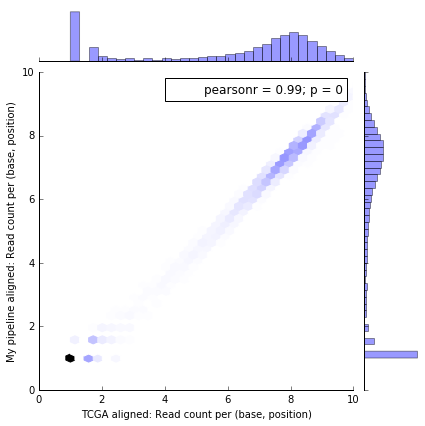

In [168]:
g=sns.jointplot(data=inPlotDf,x=ctrl_label,y=case_label,kind='hex',xlim=[0,10],ylim=[0,10])
g.savefig('./TCGA_compare.pdf')
g.savefig('./TCGA_compare.png',dpi=300)

Conclusion: Counts of the ACGT are highly similar between my simplified pipeline as compared to TCGA. 

### plot alternative alleles

In [169]:
### identify reference allelels
tmpDf_all=pd.read_csv('./2b0048e0-a062-40d2-a1e1-4bb763ea0ead.snp.txt.gz',
                      sep='\s+',header=None,names=np.arange(50),index_col=None,error_bad_lines=False)
myCols=['Chr','Pos','Ref','rd_all','','A','C','G','T','N']
tmpDf=tmpDf_all.iloc[:,:len(myCols)]
tmpDf.columns=myCols
myReindexedDf=tmpDf.set_index(['Ref','Chr','Pos'])
refIndex=myReindexedDf.index

In [170]:
##  extract non reference alleles
altAllelDf=inPlotDf[~inPlotDf.index.isin(refIndex)]

In [171]:
m1=altAllelDf[ctrl_label]>1.0
inPlotDf2=altAllelDf[m1]

In [172]:
print 'Alternative alleles only (n='+str(inPlotDf2.shape[0])+')'

Alternative alleles only (n=31370)


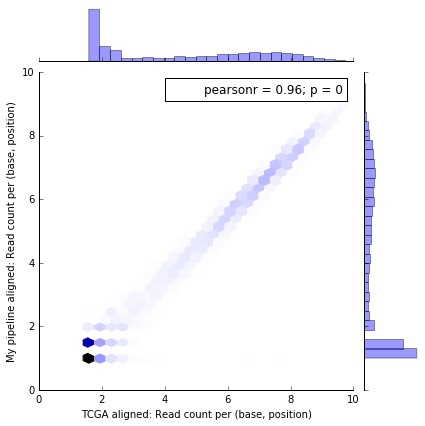

In [173]:
g=sns.jointplot(data=inPlotDf2,x=ctrl_label,y=case_label,kind='hex',xlim=[0,10],ylim=[0,10])
g.savefig('./TCGA_compare.alternative_allele.pdf')
g.savefig('./TCGA_compare.alternative_allele.png',dpi=300)

Conclusion: 
Some people might wonder 
Counts of the ACGT are highly similar between my simplified pipeline as compared to TCGA even among just the reference alleles. 